# Project1: Writing a Data Scientist Blog Post

## Business understanding
there are questions I wnat to explore in stackoverflow survet at 2021   
1. What is population of codeing language at 2021 ?
2. How well can we predict the the frequency of visiting Stack Overflow? What variables correlate well with the frequency of visiting Stack Overflow ? 
3. How well can we predict the the frequency of participation in Q&amp;A on Stack Overflow?(ask, answer, vote for, or comment on questions.) What variables correlate well with the frequency of participation ?  


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

In [120]:
pd.set_option('display.max_columns',500)
df = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv')
df.shape

(83439, 48)

In [121]:
df.head()

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,YearsCodePro,DevType,OrgSize,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSys,NEWStuck,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,NEWOtherComms,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,NaN,"Developer, mobile",20 to 99 employees,EUR European Euro,4800.0,Monthly,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,Swift,PostgreSQL;SQLite,SQLite,NaN,NaN,Laravel;Symfony,NaN,NaN,NaN,NaN,NaN,PHPStorm;Xcode,Atom;Xcode,MacOS,Call a coworker or friend;Visit Stack Overflow...,Stack Overflow,Multiple times per day,Yes,A few times per month or weekly,"Yes, definitely",No,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript;Python,NaN,PostgreSQL,NaN,NaN,NaN,Angular;Flask;Vue.js,NaN,Cordova,NaN,Docker;Git;Yarn,Git,Android Studio;IntelliJ;Notepad++;PyCharm,NaN,Windows,Visit Stack Overflow;Google it,Stack Overflow,Daily or almost daily,Yes,Daily or almost daily,"Yes, definitely",No,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,Julia;Python;Rust,SQLite,SQLite,Heroku,NaN,Flask,Flask,NumPy;Pandas;TensorFlow;Torch/PyTorch,Keras;NumPy;Pandas;TensorFlow;Torch/PyTorch,NaN,NaN,IPython/Jupyter;PyCharm;RStudio;Sublime Text;V...,IPython/Jupyter;RStudio;Sublime Text;Visual St...,MacOS,Visit Stack Overflow;Google it;Watch help / tu...,Stack Overflow;Stack Exchange,Multiple times per day,Yes,Multiple times per day,"Yes, definitely",Yes,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,NaN,"Developer, front-end",100 to 499 employees,EUR European Euro,NaN,Monthly,JavaScript;TypeScript,JavaScript;TypeScript,NaN,NaN,NaN,NaN,Angular;jQuery,Angular;jQuery,NaN,NaN,NaN,NaN,NaN,NaN,Windows,Call a coworker or friend;Visit Stack Overflow...,Stack Overflow,Daily or almost daily,Yes,Daily or almost daily,Neutral,No,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,10,"Developer, desktop or enterprise applications;...","Just me - I am a freelancer, sole proprietor, ...",GBP\tPound sterling,NaN,NaN,Bash/Shell;HTML/CSS;Python;SQL,Bash/Shell;HTML/CSS;Python;SQL,Elasticsearch;PostgreSQL;Redis,Cassandra;Elasticsearch;PostgreSQL;Redis,Na

## Question 1

**1.** In order to understand What is population of coding language at 2021 ?, Take a look at the **LanguageHaveWorkedWith** and **LanguageWantToWorkWith** columns. 

In [143]:
# This function is used to split the string data into string categorical data 
# from specific column, then counts the numbers of each categorical data, 
# storing the categorical data and counts into a short dataframe

def split_to_unique(df,col,split_by=';'):
    '''
    Input:
    df - dataframe
    col - col string from dataframe columns
    split_by - the para used in split()
    Output:
    df - dataframe with two columns.
    '''
    col_lst = defaultdict(int)
    for i in df[col].dropna():
        str_lst = i.split(split_by)
        for j in str_lst:
            col_lst[j] +=1 
    col_df = pd.DataFrame(pd.Series(col_lst),columns=['Cnts'])
    col_df = col_df.sort_values(by='Cnts',ascending=False)
    
    return col_df

def bar_plot(df,title):
    '''
    Input:
    df - dataframe
    title - title string
    '''
    plt.figure(figsize=(15,5))
    plt.bar(df.index,df[df.columns[0]]);
    plt.title(title)
    plt.xticks(rotation=90);
    
    return

In [144]:
language_df = split_to_unique(df,'LanguageHaveWorkedWith',split_by=';')

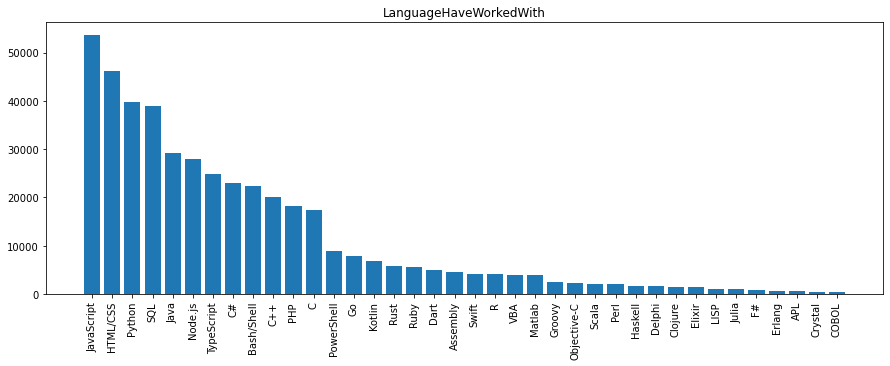

In [102]:
bar_plot(language_df,'LanguageHaveWorkedWith')

From bar chart above, we can see the first five languages are **JavaScript, HTML/CSS, Python, SQL, Java?**. which results wonder me does it mean that the most of people, filling this survey, are working at front-end area ? The inference is based on we knew JavaScript and HTML/CSS are mainly for front-end development or full-stack development.  
  
**2.** Take a loot at the **DevType** to see What is the distribution of job type ? 

In [103]:
DevType_df = split_to_unique(df,'DevType',split_by=';')

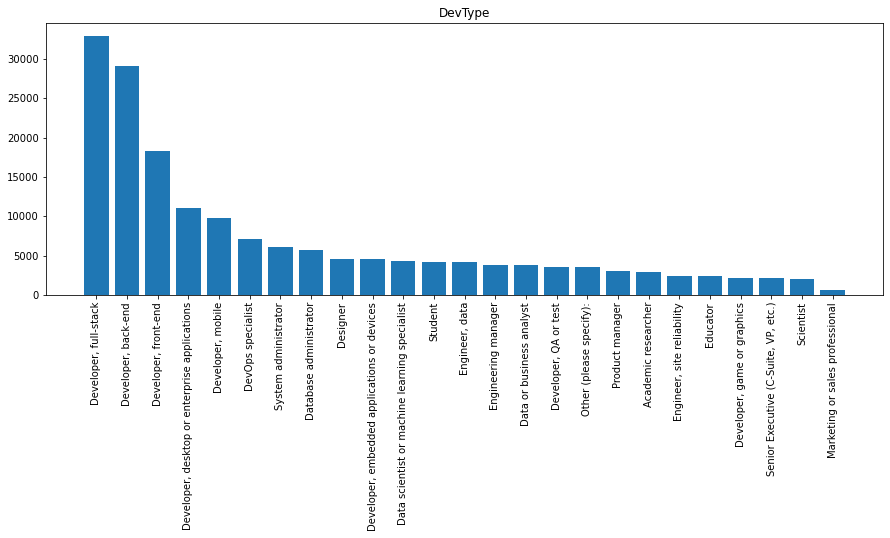

In [104]:
bar_plot(DevType_df,'DevType')

From above charts, we can see the first three development types are **full-stack, back-end, front-end**  
With only the chart of **Language Have Worked With** we can't tell what developer types are dominating numbers in our survey, each person with a specific development type could have mulitple language skills, like: Person A with back-end developer may have javascript, HTML/CSS skill too. 
However, with the chart of development type. we can say full-stack is our first dominating developer types in our survey population  

## Question 2

How well can we predict the the frequency of visiting Stack Overflow? What variables correlate well with the frequency of visiting Stack Overflow ?

### Data understanding    
As browsing the raw data by dataframe.dtypes, we can see most of data types are oject, which means we need to deal with categorical variables, drop missing data or impute values if necessaryt at data preparation  

In [148]:
# Our predict variable is categorical, ordinary data.  we can sort it by numbers based on categorical data contents
# Frequency from more to less(5~1):
# 'Multiple times per day':5
# 'Daily or almost daily':4
# 'A few times per week':3
# 'A few times per month or weekly':2
# 'Less than once per month or monthly':1
df['SOVisitFreq'].dropna().unique()

array(['Multiple times per day', 'Daily or almost daily',
       'A few times per week', 'A few times per month or weekly',
       'Less than once per month or monthly'], dtype=object)

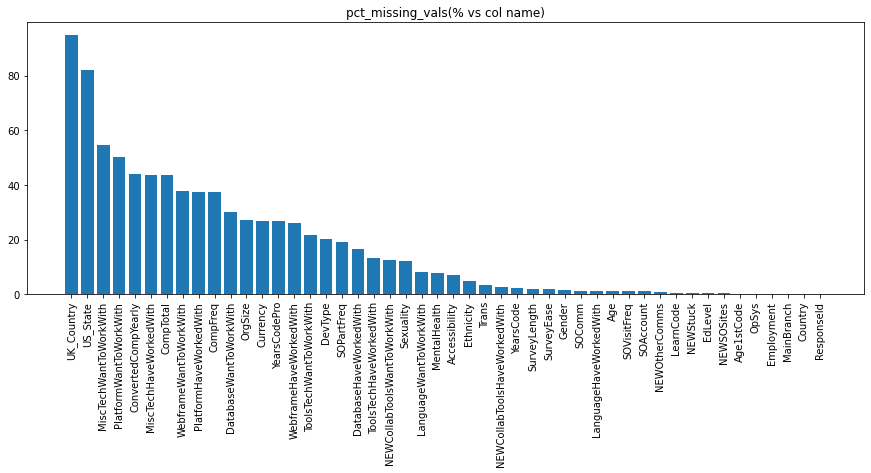

In [147]:
# check the missing values percentage at each column
pct_mis_dict = defaultdict(int)
for i in df.columns:
    pct_mis_dict[i] = df[i].isnull().mean()*100
pct_mis_df = pd.DataFrame(pd.Series(pct_mis_dict),columns=['pct_missing_vals'])
pct_mis_df = pct_mis_df.sort_values(by='pct_missing_vals',ascending=False)
# plot
bar_plot(pct_mis_df,'pct_missing_vals(% vs col name)')

### Prepare data

## Question 3

How well can we predict the the frequency of participation in Q&A on Stack Overflow?(ask, answer, vote for, or comment on questions.) What variables correlate well with the frequency of participation ?